In [1]:
#import nltk
#from nltk.tokenize import word_tokenize
#from nltk.tag import pos_tag
#from IPython.display import display
#from spacy import displacy
from nltk.stem import PorterStemmer #WordNetLemmatizer
import re
#import random
#import pickle
import os
import pandas as pd
from itertools import tee, product
from collections import defaultdict

In [2]:
from nltk.corpus import brown
from nltk.corpus import inaugural
from nltk.corpus import reuters
from nltk.corpus import stopwords

# science corpora location
parent_dir = '/Users/trinhsk/Documents/Biomedical-Corpora/corpora/NER/CoNLL/BIO/'

In [3]:
# generate taxonomy word pairs 
taxon_file = 'taxon_names.csv'
taxon_name_df = pd.read_csv(taxon_file)
tx_df = taxon_name_df[~taxon_name_df.unit_name1.isnull()][~taxon_name_df.unit_name2.isnull()]
tx_df['full_name'] = tx_df['unit_name1'] + " " + tx_df['unit_name2']
tx_df.head()

,unit_name1,unit_name2,full_name
8,Nitrobacter,agilis,Nitrobacter agilis
9,Nitrobacter,flavus,Nitrobacter flavus
10,Nitrobacter,oligotrophis,Nitrobacter oligotrophis
11,Nitrobacter,polytrophus,Nitrobacter polytrophus
12,Nitrobacter,punctata,Nitrobacter punctata


In [4]:
def filter_nonchar(paragraph_list):
    """if any non-char is present or numeric and not a stop word and length > 3 and excludes ATGC nucleic acids"""
    return [s for s in paragraph_list if not re.search(r'[\W+\d+]', s) and \
            s not in stop_words_list and \
            len(s) > 3 and \
            re.search(r'[^ATCG]', s)]

In [5]:
# english stopwords
stop_words_list = stopwords.words('english')

In [6]:
#eng_corpus_names = ['brown', 'inaugural', 'reuters']

def clean_list_words(list_words):
    # clean the sci corpora 
    tmp = filter_nonchar(list_words)
    try:
        tmp.remove('Saccharomyces')
        tmp.remove('cerevisiae')
        tmp.remove('Escherichia')
        tmp.remove('coli')
        tmp.remove('Solanum')
        tmp.remove('tuberosum')
        tmp.remove('Xenopus')
        tmp.remove('Chromobacterium')
        tmp.remove('violacium')
    except ValueError:
        pass
    tmp = list(dict.fromkeys(tmp).keys()) # similar to a set of unique values
    return tmp

def generate_paragraph_dicts():
    # for use with the normal english corpora
    tmp_dict = defaultdict(list)
    # the normal english corpora
    for corpus in [brown, inaugural, reuters]:
        # flatten the list of lists and filter
        eng_list_words = filter_nonchar(list(dict.fromkeys([paragraph for \
                                                                      sentence in corpus.sents() for \
                                                                      paragraph in sentence]).keys()))
        tmp_dict['words'].append(eng_list_words)
    
    # make unique set of words by passing it thru dict object
    eng_word_list = list(dict.fromkeys([ls for sl in tmp_dict['words'] for ls in sl]).keys())
    
    return eng_word_list

In [7]:
def clean_sci_words():
    sci_list_words = []
    for fi in os.listdir(parent_dir):
        if os.path.exists(os.path.join(parent_dir, fi, 'valid.tsv')):
            fp = os.path.join(parent_dir, fi, 'valid.tsv')
            tmp_df = pd.read_csv(fp, sep='\t')
            # filter values with nan and non-word characters
            sci_list_words.append(clean_list_words(tmp_df.iloc[:, 0][~tmp_df.iloc[:,0].isnull()].values.tolist()))
    return sci_list_words

sci_word_list = clean_sci_words()

sci_word_list = list(dict.fromkeys([ls for sl in sci_word_list for ls in sl]).keys()) # flatten list

In [8]:
len(sci_word_list) 

43473

In [9]:
def pairwise(iterable):
        """s -> (s0,s1), (s1,s2), (s2, s3), ..."""
        a, b = tee(iterable) # iterator splits the container into a number of iterators mentioned in the argument; default is 2
        next(b, None) #suppresses stopiteration error when exhausted list and offsets the second word over to next iteration
        return zip(a, b)

In [10]:
# generate all the english word pairs from the three regular english corpora & two science corpora
eng_word_list = generate_paragraph_dicts()

In [11]:
len(eng_word_list)

67773

In [12]:
vowels = "aeiouyAEIOUY"

def calc_vowels_consonants_syllable(word):
    word = word.lower()
    SYLLABLE = 0
    VOWELS = 0
    CONSONANTS = 0
    if word[0] in vowels:
        SYLLABLE += 1
    for index in range(1, len(word)):
        if word[index] in vowels and word[index - 1] not in vowels:
            SYLLABLE += 1
        if word[index] in vowels:    
            VOWELS += 1
        else:
            CONSONANTS += 1
    if word.endswith("e"):
        SYLLABLE -= 1
    if SYLLABLE == 0:
        SYLLABLE += 1
    return VOWELS, CONSONANTS, SYLLABLE

In [13]:
def ratio_vow_sub_word(sub_word):
    """get ratio of vowel to sub-word"""
    try:
        cnt_vow = len(re.findall(rf'[{sub_word}]', vowels))
        return cnt_vow/len(sub_word)
    except AttributeError:
        return 0

In [14]:
def case_letter(two_words):
    """split two words and capitalize the first letter of first word"""
    tmp_ = two_words.split(' ')
    w_1 = tmp_[0].lower().capitalize()
    w_2 = tmp_[1].lower()
    return w_1, w_2

In [15]:
def last_char(word):
    '''
    Extract the last three characters of the word
    '''
    return word[-3:]
    
def first_char(word):
    '''
    Extract the first two characters of the word
    '''
    return word[:3]

def preprocess_word(word):
    processed_word = re.sub(r'[^A-Za-z-]', '', word) # remove special chars
    return processed_word

def find_features(two_words):
    '''
    feature extraction and store into dictionary for training
    '''
    word_dict = {}
    for i,w in enumerate(two_words.split(' ')):
        if i == 0: # lowercase and captailize first letter of first word
            w = w.lower().capitalize()
        else:
            w = w.lower()
        n_vowels, n_consonants, n_syllables = calc_vowels_consonants_syllable(w)
        word_dict[i] = {
                                'word': preprocess_word(w),
                                'n_vowels' : n_vowels,
                                'n_consonants' : n_consonants,
                                'n_syllables' : n_syllables,
                                'word_length' : len(w) 
                        }
        
        try:
            word_dict[i]['ratio_vow_con']  = n_vowels/n_consonants   
        except ZeroDivisionError:
            word_dict[i]['ratio_vow_con'] = 1 

        try:
            word_dict[i]['ratio_vow_syl'] = n_vowels/n_syllables
        except ZeroDivisionError:
            word_dict[i]['ratio_vow_syl'] = 1

    f_char_1 = first_char(word_dict[0]['word'])
    f_char_2 = first_char(word_dict[1]['word'])
    l_char_1 = last_char(word_dict[0]['word'])
    l_char_2 = last_char(word_dict[1]['word'])
    
    return {'word_length_1': word_dict[0]['word_length'],\
            'word_length_2': word_dict[1]['word_length'],\
            'last_letters_1': l_char_1,\
            'last_letters_2': l_char_2,\
            'first_letters_1': f_char_1,\
            'first_letters_2': f_char_2,\
            'stem_1':stem_compute_v2(word_dict[0]['word']),\
            'stem_2':stem_compute_v2(word_dict[1]['word']),\
            'vowel_ratio_1':word_dict[0]['n_vowels']/word_dict[0]['word_length'],\
            'vowel_ratio_2':word_dict[1]['n_vowels']/word_dict[1]['word_length'],\
            'consonant_ratio_1':word_dict[0]['n_consonants']/word_dict[0]['word_length'],\
            'consonant_ratio_2':word_dict[1]['n_consonants']/word_dict[1]['word_length'],\
            'syllable_ratio_1':word_dict[0]['n_syllables']/word_dict[0]['word_length'], \
            'syllable_ratio_2':word_dict[1]['n_syllables']/word_dict[1]['word_length'], \
            'ratio_vow_con_1': word_dict[0]['ratio_vow_con'],\
            'ratio_vow_con_2': word_dict[1]['ratio_vow_con'],\
            'ratio_vow_syl_1': word_dict[0]['ratio_vow_syl'],\
            'ratio_vow_syl_2': word_dict[1]['ratio_vow_syl']
            #'vow_f_lt_1' : ratio_vow_sub_word(f_char_1),\
            #'vow_f_lt_2' : ratio_vow_sub_word(f_char_2),\
            #'vow_l_lt_1' : ratio_vow_sub_word(l_char_1),\
            #'vow_l_lt_2' : ratio_vow_sub_word(l_char_2)
            #'lemma_word_1' : lemma_binary(word_dict[0]['word']),\
            #'lemma_word_2' : lemma_binary(word_dict[1]['word'])
           }



stemmer = PorterStemmer()
#lemmatiser = WordNetLemmatizer()


def stem_compute_v2(word):
    '''
    Output ratio of stem word to original word
    '''
    s_word = stemmer.stem(word)
    word_length = len(word)
    stem_length = len(s_word)
    try:
        ratio = stem_length / word_length
    except ZeroDivisionError:
        ratio = 1
    return ratio

def lemma_binary(word):
    '''
    Output overlapping words from a lemmatised word compared to the original word
    '''
    l_word = lemmatiser.lemmatize(word)
    word_lemma_dict = {'word_length' : len(word), 'lw_length' : len(l_word)}
    max_length = max(word_lemma_dict.values())
    longer_length_word = [k for k,v in word_lemma_dict.items() if v == max_length][0]
    for _ in range(max_length - word_lemma_dict['lw_length']):
        l_word += '0'
    binary_output = []
    for w,lw in zip(word,l_word):
        if w == lw:
            binary_output.append(1)
        else:
            binary_output.append(0)

    try:
        output = binary_output.count(1)/len(binary_output)
    except ZeroDivisionError:
        output = 1
    return output

In [16]:
cp_tx_df = tx_df.copy()

In [17]:
# just to get the column names
col_names = [cn for cn in find_features('Flavobacterium acetylicum').keys()]
col_names

['word_length_1',
 'word_length_2',
 'last_letters_1',
 'last_letters_2',
 'first_letters_1',
 'first_letters_2',
 'stem_1',
 'stem_2',
 'vowel_ratio_1',
 'vowel_ratio_2',
 'consonant_ratio_1',
 'consonant_ratio_2',
 'syllable_ratio_1',
 'syllable_ratio_2',
 'ratio_vow_con_1',
 'ratio_vow_con_2',
 'ratio_vow_syl_1',
 'ratio_vow_syl_2']

In [18]:
# find features of each taxonomy name pair then append in list to insert into pandas df
row_data = []
for n in cp_tx_df['full_name']:
    tmp_dict = find_features(n)
    row_data.append([n] + [vals for vals in tmp_dict.values()])

In [19]:
# create dataframe with features and word pair
df_tx_feats = pd.DataFrame(data=row_data, columns=['word_pair'] + col_names)
# add class column
df_tx_feats['class'] = True
# shuffle dataframe
df_tx_feats = df_tx_feats.sample(frac=1).reset_index(drop=True)
df_tx_feats.head()

,word_pair,word_length_1,word_length_2,last_letters_1,last_letters_2,first_letters_1,first_letters_2,stem_1,stem_2,vowel_ratio_1,vowel_ratio_2,consonant_ratio_1,consonant_ratio_2,syllable_ratio_1,syllable_ratio_2,ratio_vow_con_1,ratio_vow_con_2,ratio_vow_syl_1,ratio_vow_syl_2,class
0,Matucana variabilis,8,10,ana,lis,Mat,var,1.000000,0.900000,0.500000,0.500000,0.375000,0.400000,0.500000,0.400000,1.333333,1.250000,1.00,1.250000,True
1,Nebria gregaria,6,8,ria,ria,Neb,gre,1.000000,1.000000,0.500000,0.500000,0.333333,0.375000,0.333333,0.375000,1.500000,1.333333,1.50,1.333333,True
2,Melanodryas vittata,11,7,yas,ata,Mel,vit,0.909091,1.000000,0.454545,0.428571,0.454545,0.428571,0.363636,0.428571,1.000000,1.000000,1.25,1.000000,True
3,Abronia orbiculata,7,10,nia,ata,Abr,orb,1.000000,1.000000,0.428571,0.400000,0.428571,0.500000,0.428571,0.500000,1.000000,0.800000,1.00,0.800000,True
4,Lysionotus pauciflorus,10,11,tus,rus,Lys,pau,0.900000,0.909091,0.500000,0.454545,0.400000,0.454545,0.400000,0.363636,1.250000,1.000000,1.25,1.250000,True


In [20]:
df_tx_feats.shape

(741840, 20)

In [21]:
def gen_word_df(word_list):
    """attach two separate df together from two separate loops; 
    only desire fraction of the normal english word pairs and 
    primarily from science corpora"""
    row_data = []
    for w1, w2 in pairwise(word_list):
        row_data.append(f'{w1} {w2}')
    
    tmp_df = pd.DataFrame(data=row_data, columns=['word_pair'])
    tmp_df = tmp_df.sample(frac=1).reset_index(drop=True)
    
    return tmp_df
    
    
eng_df = gen_word_df(eng_word_list)
# take ~ 17% rows of this normal eng corpora
eng_df = eng_df[:int(round(0.17*eng_df.shape[0]))]
# include the entire science corpora
sci_df = gen_word_df(sci_word_list) 
eng_sci_df = eng_df.append(sci_df)
eng_sci_df.shape

(54993, 1)

In [22]:
eng_sci_df.sample(60)

,word_pair
22405,Hind linkers
5270,Thesaurus comma
19632,chelator deferoxamine
33437,desferoxamine unabsorbed
5807,Lust vanishes
18744,enylidene semicarbazide
2202,ROOHs alterated
18275,rarest neuroleptics
10777,eloquence Eleazar
34142,Frederic Calculated


In [23]:
row_data = []
for wp in eng_sci_df['word_pair']:
    tmp_dict = find_features(wp)
    row_data.append([wp] + [vals for vals in tmp_dict.values()])

eng_sci_df = pd.DataFrame(data = row_data, columns=list(eng_sci_df) + col_names)
eng_sci_df['class'] = False

In [24]:
# shuffle the dataframe 
eng_sci_df = eng_sci_df.sample(frac=1).reset_index(drop=True)
eng_sci_df.head(25)

,word_pair,word_length_1,word_length_2,last_letters_1,last_letters_2,first_letters_1,first_letters_2,stem_1,stem_2,vowel_ratio_1,vowel_ratio_2,consonant_ratio_1,consonant_ratio_2,syllable_ratio_1,syllable_ratio_2,ratio_vow_con_1,ratio_vow_con_2,ratio_vow_syl_1,ratio_vow_syl_2,class
0,AGHD reconsidered,4,12,ghd,red,Agh,rec,1.000000,0.666667,0.000000,0.416667,0.750000,0.500000,0.250000,0.416667,0.000000,0.833333,0.000000,1.000000,False
1,Diazonium Electrografting,9,15,ium,ing,Dia,ele,1.000000,0.800000,0.555556,0.266667,0.333333,0.666667,0.333333,0.333333,1.666667,0.400000,1.666667,0.800000,False
2,orotates monoanion,8,9,tes,ion,Oro,mon,0.500000,1.000000,0.375000,0.555556,0.500000,0.333333,0.500000,0.333333,0.750000,1.666667,0.750000,1.666667,False
3,montana Sanjappa,7,8,ana,ppa,Mon,san,1.000000,1.000000,0.428571,0.375000,0.428571,0.500000,0.428571,0.375000,1.000000,0.750000,1.000000,1.000000,False
4,DCPA herbicide,4,9,cpa,ide,Dcp,her,1.000000,0.888889,0.250000,0.444444,0.500000,0.444444,0.250000,0.333333,0.500000,1.000000,1.000000,1.333333,False
5,Arbor Michigan,5,8,bor,gan,Arb,mic,1.000000,1.000000,0.200000,0.375000,0.600000,0.500000,0.400000,0.375000,0.333333,0.750000,0.500000,1.000000,False
6,Scattering Roughness,10,9,ing,ess,Sca,rou,0.700000,0.555556,0.300000,0.333333,0.600000,0.555556,0.300000,0.222222,0.500000,0.600000,1.000000,1.500000,False
7,conflict must,8,4,ict,ust,Con,mus,1.000000,1.000000,0.250000,0.250000,0.625000,0.500000,0.250000,0.250000,0.400000,0.500000,1.000000,1.000000,False
8,Tricks Scapin,6,6,cks,pin,Tri,sca,0.833333,1.000000,0.166667,0.333333,0.666667,0.500000,0.166667,0.333333,0.250000,0.666667,1.000000,1.000000,False
9,underlayer thicknesses,10,11,yer,ses,Und,thi,0.800000,0.454545,0.400000,0.272727,0.500000,0.636364,0.300000,0.272727,0.800000,0.428571,1.333333,1.000000,False


In [25]:
df_comb_words = eng_sci_df.append(df_tx_feats.iloc[:eng_sci_df.shape[0]]) #combine eng df and tx df of same length (rows)
df_comb_words = df_comb_words.sample(frac=1).reset_index(drop=True) # shuffle the rows

In [26]:
def convert_to_binary(df):
    """convert the first and last letters to binary"""
    for i in range(1,3):
        df[f'last_letters_{i}'] = df[f'last_letters_{i}'].apply(lambda x: ''.join(format(ord(w), 'b') for w in x) )
        df[f'first_letters_{i}'] = df[f'first_letters_{i}'].apply(lambda x: ''.join(format(ord(w), 'b') for w in x) )
    return df

In [27]:
df_comb_words.shape

(109986, 20)

In [28]:
df_comb_words = convert_to_binary(df_comb_words)
df_comb_words.sample(50)

,word_pair,word_length_1,word_length_2,last_letters_1,last_letters_2,first_letters_1,first_letters_2,stem_1,stem_2,vowel_ratio_1,vowel_ratio_2,consonant_ratio_1,consonant_ratio_2,syllable_ratio_1,syllable_ratio_2,ratio_vow_con_1,ratio_vow_con_2,ratio_vow_syl_1,ratio_vow_syl_2,class
100516,Colour Brougher,6,8,110111111101011110010,110100011001011110010,100001111011111101100,110001011100101101111,1.000000,1.000000,0.500000,0.375000,0.333333,0.500000,0.333333,0.250000,1.500000,0.750000,1.500000,1.500000,False
21322,abstinence biometry,10,8,110111011000111100101,111010011100101111001,100000111000101110011,110001011010011101111,0.600000,1.000000,0.300000,0.500000,0.600000,0.375000,0.300000,0.375000,0.500000,1.333333,1.000000,1.333333,False
65248,Sphedanolestes bastardi,14,8,111010011001011110011,111001011001001101001,101001111100001101000,110001011000011110011,0.857143,1.000000,0.357143,0.375000,0.571429,0.500000,0.357143,0.375000,0.625000,0.750000,1.000000,1.000000,True
10439,Condica leucorena,7,9,110100111000111100001,110010111011101100001,100001111011111101110,110110011001011110101,1.000000,1.000000,0.428571,0.555556,0.428571,0.333333,0.428571,0.444444,1.000000,1.666667,1.000000,1.250000,True
13567,beeing earmark,6,7,110100111011101100111,110000111100101101011,100001011001011100101,110010111000011110010,0.500000,1.000000,0.500000,0.285714,0.333333,0.571429,0.166667,0.285714,1.500000,0.500000,3.000000,1.000000,False
72365,stricly Krueger,7,7,110001111011001111001,110011111001011110010,101001111101001110010,110101111100101110101,1.000000,1.000000,0.285714,0.428571,0.571429,0.428571,0.285714,0.285714,0.500000,1.000000,1.000000,1.500000,False
62065,Anti polyacrylamide,4,14,110111011101001101001,110100111001001100101,100000111011101110100,111000011011111101100,1.000000,0.928571,0.250000,0.500000,0.500000,0.428571,0.500000,0.357143,0.500000,1.166667,0.500000,1.400000,False
35652,Trypophloeus salicis,12,7,110010111101011110011,110001111010011110011,101010011100101111001,111001111000011101100,0.916667,0.857143,0.416667,0.428571,0.500000,0.428571,0.250000,0.428571,0.833333,1.000000,1.666667,1.000000,True
56215,PRETAX PROFITS,6,7,111010011000011111000,110100111101001110011,101000011100101100101,111000011100101101111,1.000000,0.857143,0.333333,0.285714,0.500000,0.571429,0.333333,0.285714,0.666667,0.500000,1.000000,1.000000,False
59931,Annatira affinis,8,7,110100111100101100001,110111011010011110011,100000111011101101110,110000111001101100110,1.000000,0.857143,0.375000,0.285714,0.500000,0.571429,0.500000,0.428571,0.750000,0.500000,0.750000,0.666667,True


In [29]:
#Create x and y variables.
def output_X_y(df,feature_names):
    X = df.drop(columns=['class'])
    X = X[feature_names]
    y = df['class']
    return X, y

In [30]:
from sklearn.preprocessing import LabelEncoder
from nltk.classify.scikitlearn import SklearnClassifier
from sklearn.neighbors import KNeighborsClassifier
#from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, ComplementNB
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
#from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import NMF
import numpy as np
import matplotlib.pyplot as plt
from sklearn.multiclass import OneVsRestClassifier # for LinearSVC ROC plotting
#import seaborn as sns
import joblib # to pickle gridesearchcv best estimators

In [31]:
feature_names = list(df_comb_words)[1:-1] #exclude the word pair and the class

In [32]:
X, y = output_X_y(df_comb_words, feature_names)
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.12, random_state=4)

In [115]:
# Fit on training set only
def run_scale_pca(train_x, test_x):
    sc = StandardScaler()
    X_train = sc.fit_transform(train_x)
    X_test = sc.transform(test_x)
    pca = PCA(0.95)
    X_train = pca.fit_transform(X_train)
    X_test = pca.transform(X_test)
    return pca, X_train, X_test

# return the eig components and varaince
def eig_exp_var(X_train):
    features = X_train.T
    cov_matrix = np.cov(features)
    eigval,eigvec = np.linalg.eig(cov_matrix)
    tot = sum(eigval) 
    var_exp = [(i/tot)*100 for i in sorted(eigval, reverse=True)]
    cum_var_exp = np.cumsum(var_exp)
    return eigval, eigvec, var_exp, cum_var_exp

# scree plot
def plot_exp_var(eigval, eigvec, var_exp, cum_var_exp):
    plt.figure(figsize=(6, 4))
    plt.bar(range(eigval.shape[0]), var_exp, alpha=0.5, align='center',
            label='individual explained variance')
    plt.step(range(eigval.shape[0]), cum_var_exp, where='mid',
             label='cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')

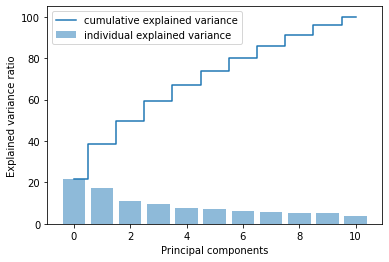

In [116]:
pca, X_train, X_test = run_scale_pca(train_x[:5000], test_x[:5000])

eigval, eigvec, var_exp, cum_var_exp = eig_exp_var(X_train)

plot_exp_var(eigval, eigvec, var_exp, cum_var_exp)

In [33]:
''' RANDOMSIED HYPERPARAMTER TUNING RANDOMFOREST'''
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 105, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]# Create the random grid

random_grid_randfor = {'clf__n_estimators': n_estimators,
                       'clf__max_features': max_features,
                       'clf__max_depth': max_depth,
                       'clf__min_samples_split': min_samples_split,
                       'clf__min_samples_leaf': min_samples_leaf,
                       'clf__bootstrap': bootstrap,
                       'pca__n_components' : list(range(2,train_x.shape[1] + 1,2))
                        }

In [34]:
''' RANDOMISED HYPERPARAMETER TUNING KNN '''

random_grid_knn = dict(pca__n_components=list(range(8,train_x.shape[1]+1,2)),
                      clf__leaf_size=list(range(1,4)), 
                      clf__n_neighbors=list(range(2,6)),
                      clf__p=[1,2],
                      clf__weights=['uniform', 'distance'],
                      clf__algorithm=['auto', 'ball_tree','kd_tree','brute'])

In [61]:
''' RANDOMISED HYPERPARAMETER TUNING LINEAR SVC '''

random_grid_linsvc = dict(pca__n_components=list(range(8,train_x.shape[1]+1,2)),
                      clf__C=np.linspace(4,20,6), # Regularization parameter. The strength of the regularization is inversely proportional to C; controls the trade-off between achieving a low error on the training data and minimising the norm of the weights
                      clf__dual=[False], # when n_samples > n_features; suppresses convergence error
                      clf__loss=['hinge', 'squared_hinge'],
                      clf__penalty=['l1', 'l2'],
                      clf__max_iter=[2000,2500])

In [36]:
''' RANDOMISED HYPERPARAMETER TUNING SGD '''
import scipy.stats as stats
from sklearn.utils.fixes import loguniform

random_grid_sgd = dict(pca__n_components=list(range(8,train_x.shape[1]+1,2)),
                       clf__average=[True, False],
                       clf__l1_ratio=stats.uniform(0, 1), # A uniform continuous random variable (straight line)
                       clf__alpha=loguniform(1e-5, 1e0), # pdf probabilty density function; continuous random variable (L-shape curved line)
                       clf__penalty=['l2', 'l1', 'elasticnet'],
                       clf__learning_rate=['constant', 'optimal', 'invscaling', 'adaptive'],
                       clf__loss=['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron', 'squared_loss', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
                       clf__eta0=np.logspace(-5,1,5),
                       clf__max_iter=(1000, 2000))

In [37]:
''' RANDOMISED HYPERPARAMETER TUNING BERNOULLI '''

random_grid_bernoulli = dict(pca__n_components=list(range(8,train_x.shape[1]+1,2)),
                            clf__alpha=np.linspace(1e-4, 1000, 30, endpoint=True))

In [38]:
''' RANDOMISED HYPERPARAMETER TUNING LOGSITIC REGRESSION '''

random_grid_logreg = dict(pca__n_components=list(range(8,train_x.shape[1]+1,2)),
                         clf__solver=['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
                         clf__penalty=['l2', 'l1', 'elasticnet', 'none'],
                         clf__C=[300, 200, 100, 10, 1.0, 0.1, 0.01])

In [45]:
# USE RANDOMIZED PARAMETERS TO GET GENERAL IDEA OF WHAT TO TUNE 

def randsrch_clf(train_x, train_y, clf, rand_param_grid, n_iter = 100, matrix_factor=True):
    # Use the random grid to search for best hyperparameters (general region then use GridSearchCV to hone in)
    # First create the base model to tune
    # Random search of parameters, using 3 fold cross validation, 
    # search across 100 different combinations, and use all available cores
    # Fit the random search model
    if matrix_factor:
        pipe = Pipeline([('scalar', StandardScaler()), ('pca', PCA()), ('clf', clf)])
    else:
        from sklearn.decomposition import NMF 
        pipe = Pipeline([('nmf', NMF()), ('clf', clf)])
    rand_grid = RandomizedSearchCV(pipe, param_distributions=rand_param_grid, n_iter = n_iter, cv=3, n_jobs=-1, verbose=1, random_state=4)
    rand_grid.fit(train_x, train_y)
    print(rand_grid.best_score_)
    #print(rand_grid.cv_results_)
    return rand_grid

In [187]:
rf_random = randsrch_clf(train_x[:22000], train_y[:22000], RandomForestClassifier(), random_grid_randfor)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 17.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 28.9min finished


0.8447726377923841


In [188]:
rf_random.best_params_

{'pca__n_components': 12,
 'clf__n_estimators': 800,
 'clf__min_samples_split': 5,
 'clf__min_samples_leaf': 2,
 'clf__max_features': 'auto',
 'clf__max_depth': 20,
 'clf__bootstrap': True}

In [47]:
rf_random = randsrch_clf(train_x[:22000], train_y[:22000], RandomForestClassifier(), random_grid_randfor)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 14.7min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 24.9min finished


0.9791499998957448


In [48]:
rf_random.best_params_

{'pca__n_components': 14,
 'clf__n_estimators': 400,
 'clf__min_samples_split': 5,
 'clf__min_samples_leaf': 2,
 'clf__max_features': 'sqrt',
 'clf__max_depth': 62,
 'clf__bootstrap': False}

In [121]:
knn_random = randsrch_clf(train_x[:22000], train_y[:22000], KNeighborsClassifier(), random_grid_knn)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   36.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.3min finished


0.8239091253038463


In [122]:
knn_random.best_params_

{'pca__n_components': 14,
 'clf__weights': 'uniform',
 'clf__p': 2,
 'clf__n_neighbors': 5,
 'clf__leaf_size': 3,
 'clf__algorithm': 'brute'}

In [63]:
linsvc_random = randsrch_clf(train_x[:22000], train_y[:22000], LinearSVC(), random_grid_linsvc, n_iter = 288)

Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   38.3s
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed:   42.6s finished


0.8014547863586977


In [64]:
linsvc_random.best_params_

{'pca__n_components': 18,
 'clf__penalty': 'l1',
 'clf__max_iter': 2000,
 'clf__loss': 'squared_hinge',
 'clf__dual': False,
 'clf__C': 4.0}

In [110]:
sgd_random = randsrch_clf(train_x[:22000], train_y[:22000], SGDClassifier(), random_grid_sgd)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   26.2s finished


0.8047729764546775


In [111]:
sgd_random.best_params_

{'clf__alpha': 2.0330378755587583e-05,
 'clf__average': False,
 'clf__eta0': 0.31622776601683794,
 'clf__l1_ratio': 0.3757523205200838,
 'clf__learning_rate': 'adaptive',
 'clf__loss': 'hinge',
 'clf__max_iter': 1000,
 'clf__penalty': 'l2',
 'pca__n_components': 18}

In [123]:
bern_random = randsrch_clf(train_x[:33000], train_y[:33000], BernoulliNB(), random_grid_bernoulli)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   22.5s finished


0.736060606060606


In [124]:
bern_random.best_params_

{'pca__n_components': 18, 'clf__alpha': 896.5517344827587}

In [128]:
logreg_random = randsrch_clf(train_x[:33000], train_y[:33000], LogisticRegression(), random_grid_logreg)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   33.2s finished


0.8025757575757576


/Users/trinhsk/miniconda3/envs/nltk/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


In [129]:
logreg_random.best_params_

{'pca__n_components': 18,
 'clf__solver': 'newton-cg',
 'clf__penalty': 'none',
 'clf__C': 200}

In [65]:
def format_feats_into_df(word):
    df = pd.DataFrame(find_features(word).items()).transpose()
    df.columns = df.iloc[0].copy()
    df = convert_to_binary(df)
    df.drop([0], inplace=True)
    return df.iloc[0]

In [124]:
# RANDOM FOREST
param_grid_randfor = dict(pca__n_components=list(range(11,14)),
                          clf__max_depth=list(range(19,21)),
                          clf__n_estimators=list(range(775,850,25)),
                          clf__min_samples_split=list(range(4,6)),
                          clf__min_samples_leaf=list(range(1,3)),
                          clf__max_features=["auto"],
                          clf__bootstrap=[True])

In [128]:
# KNN 
param_grid_knn = dict(pca__n_components=list(range(13,16)),
                      clf__weights=['uniform'],
                      clf__p=list(range(1,4)),
                      clf__n_neighbors=list(range(4,7)),
                      clf__leaf_size=list(range(2,5)),
                      clf__algorithm=['brute'])

In [92]:
# LINEAR SVC
param_grid_linsvc = dict(pca__n_components=list(range(17,19)),
                     clf__estimator__penalty= ['l1'],
                     clf__estimator__max_iter= [2000],
                     clf__estimator__loss=['squared_hinge'],
                     clf__estimator__dual= [False],
                     clf__estimator__C=list(range(3,6)) )
# nested estimators with grid search you can scope the parameters with __ as a separator; estimator is default for teh OneVsRestClassifier

In [121]:
# SGD
param_grid_sgd = dict(clf__alpha=np.linspace(5e-2,8e-2,4),
                     clf__average= [False],
                     clf__eta0 = np.linspace(0.2,0.5,4),
                     clf__l1_ratio= np.linspace(0.2,0.5,4),
                     clf__learning_rate= ['adaptive'],
                     clf__loss=['hinge'],
                     clf__max_iter= [1000],
                     clf__penalty= ['l2'],
                     pca__n_components= list(range(17,19)))

In [126]:
# BERNOULLI
param_grid_bern= dict(clf__alpha=np.linspace(750,900,5),
                    pca__n_components= list(range(17,20)) )

In [132]:
# LOGREG 
param_grid_logreg = dict(pca__n_components= list(range(17,19)),
                        clf__solver= ['newton-cg'],
                        clf__penalty= ['none'],
                        clf__C= list(range(170,220,10)))

In [67]:
def gsrch_clf(clf, param_grid, X_train, y_train, matrix_factor=True):
    if matrix_factor:
        sc = StandardScaler()
        pca = PCA()
        pipe = Pipeline(steps=[('scaler',sc),\
                           ('pca', pca),\
                           ('clf', clf)])
    else:
        nmf = NMF()
        pipe = Pipeline(steps=[('nmf',nmf),\
                           ('clf', clf)])

    search = GridSearchCV(pipe, param_grid, n_jobs=-1, verbose=1, cv=3, scoring='accuracy')
    search.fit(X_train, y_train)
    print("Best parameter (CV score=%0.3f):" % search.best_score_)
    print(search.best_params_)

    if matrix_factor:
        # Plot the PCA spectrum after scaling
        X_train_sc = sc.fit_transform(X_train)
        pca.fit(X_train_sc)

        fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(12,12))
        ax0.plot(np.arange(1, pca.n_components_ + 1),
                 pca.explained_variance_ratio_, '+', linewidth=2) # marker as '+'
        ax0.set_ylabel('PCA explained variance ratio')

        n_pca_compts = search.best_estimator_.named_steps['pca'].n_components
        ax0.axvline(n_pca_compts,
                    linestyle=':', label=f'n_components chosen - {n_pca_compts}')
        ax0.legend(prop=dict(size=12))

        # For each number of components, find the best classifier results
        results = pd.DataFrame(search.cv_results_)
        components_col = 'param_pca__n_components'
        best_clfs = results.groupby(components_col).apply(
            lambda g: g.nlargest(1, 'mean_test_score')) # list largest row for mean_test_score

        best_clfs.plot(x=components_col, y='mean_test_score', yerr='std_test_score',
                       legend=False, ax=ax1)
        ax1.set_ylabel('Classification accuracy (val)')
        ax1.set_xlabel('n_components')
        plt.xlim(-1, pca.n_components_ + 2)
    
    print()
     
    y_pred = search.predict(test_x)
    cm = confusion_matrix(test_y, y_pred)
    print(cm)
    print()
    print('Accuracy: ' + str(accuracy_score(test_y, y_pred)))
    
    if matrix_factor:
        return {
                'gsrch_cv': search,
                'pca' : pca,
                'y_pred' : y_pred,
                'cm' : cm
        }
    else:
        return {
                'gsrch_cv': search,
                'y_pred' : y_pred,
                'cm' : cm
        }

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    9.7s finished
/Users/trinhsk/miniconda3/envs/nltk/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


Best parameter (CV score=0.803):
{'clf__C': 170, 'clf__penalty': 'none', 'clf__solver': 'newton-cg', 'pca__n_components': 18}

[[5160 1451]
 [1138 5450]]

Accuracy: 0.8038487764224562


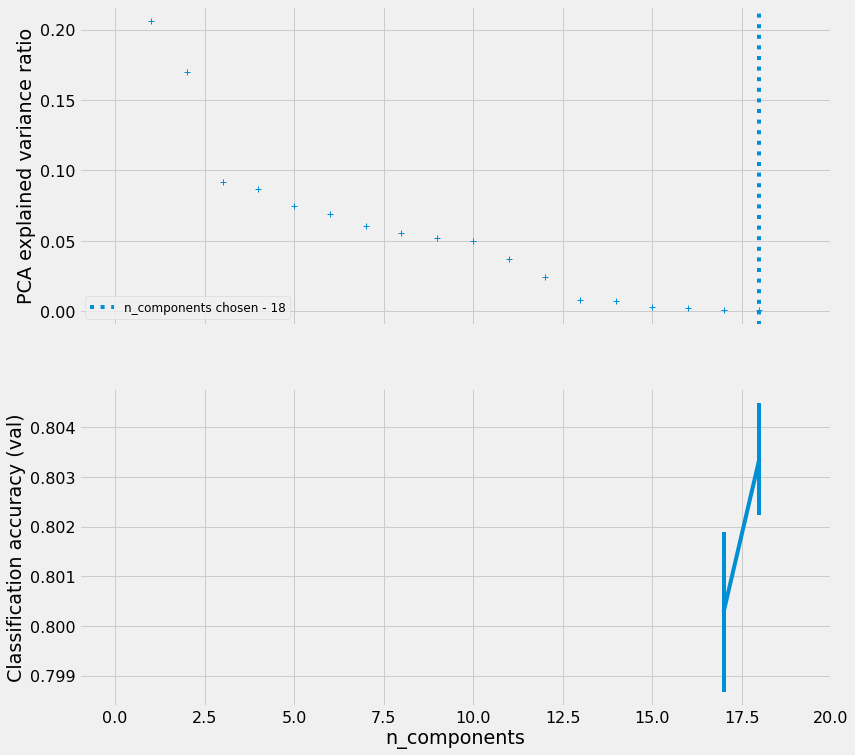

In [134]:
logreg_gsrch = gsrch_clf(LogisticRegression(), param_grid_logreg, train_x, train_y)

Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    2.8s finished


Best parameter (CV score=0.736):
{'clf__alpha': 900.0, 'pca__n_components': 18}

[[4850 1761]
 [1711 4877]]

Accuracy: 0.736949768921888


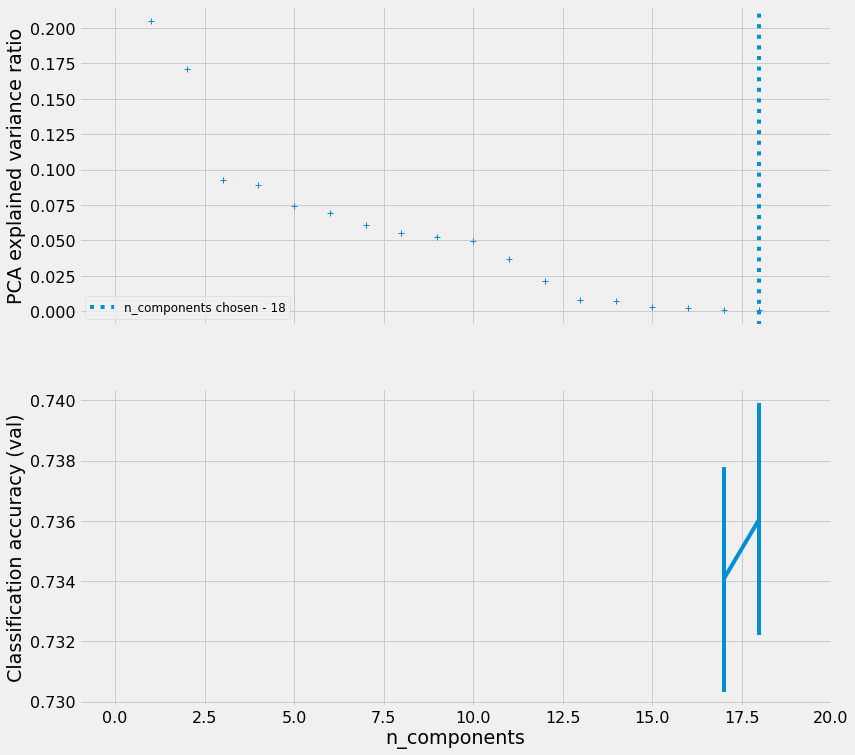

In [127]:
bern_gsrch = gsrch_clf(BernoulliNB(), param_grid_bern, train_x[:33000], train_y[:33000])

Fitting 3 folds for each of 128 candidates, totalling 384 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done 384 out of 384 | elapsed:   41.9s finished


Best parameter (CV score=0.778):
{'clf__alpha': 0.05, 'clf__average': False, 'clf__eta0': 0.4, 'clf__l1_ratio': 0.3, 'clf__learning_rate': 'adaptive', 'clf__loss': 'hinge', 'clf__max_iter': 1000, 'clf__penalty': 'l2', 'pca__n_components': 18}

[[4761 1850]
 [1103 5485]]

Accuracy: 0.77627092961588


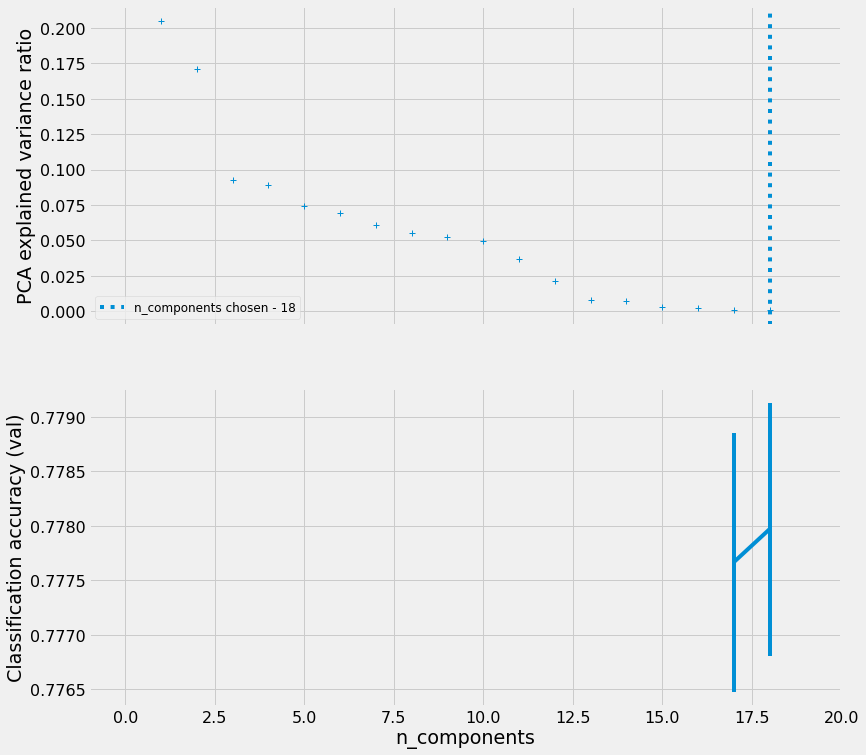

In [122]:
sgd_gsrch = gsrch_clf(SGDClassifier(), param_grid_sgd, train_x[:33000], train_y[:33000])

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    5.1s finished


Best parameter (CV score=0.804):
{'clf__estimator__C': 3, 'clf__estimator__dual': False, 'clf__estimator__loss': 'squared_hinge', 'clf__estimator__max_iter': 2000, 'clf__estimator__penalty': 'l1', 'pca__n_components': 18}

[[5117 1494]
 [1096 5492]]

Accuracy: 0.8037730131070535


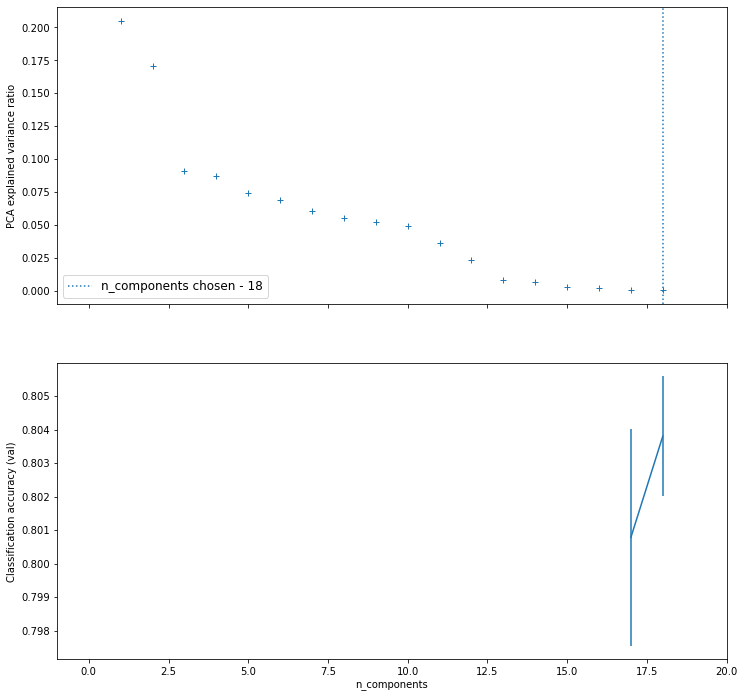

In [93]:
linsvc_gsrch = gsrch_clf(OneVsRestClassifier(LinearSVC()), param_grid_linsvc, train_x[:55000], train_y[:55000])

Fitting 3 folds for each of 81 candidates, totalling 243 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 11.6min
[Parallel(n_jobs=-1)]: Done 243 out of 243 | elapsed: 15.9min finished


Best parameter (CV score=0.827):
{'clf__algorithm': 'brute', 'clf__leaf_size': 2, 'clf__n_neighbors': 6, 'clf__p': 3, 'clf__weights': 'uniform', 'pca__n_components': 14}

[[5106 1473]
 [ 803 5817]]

Accuracy: 0.8275626941434957


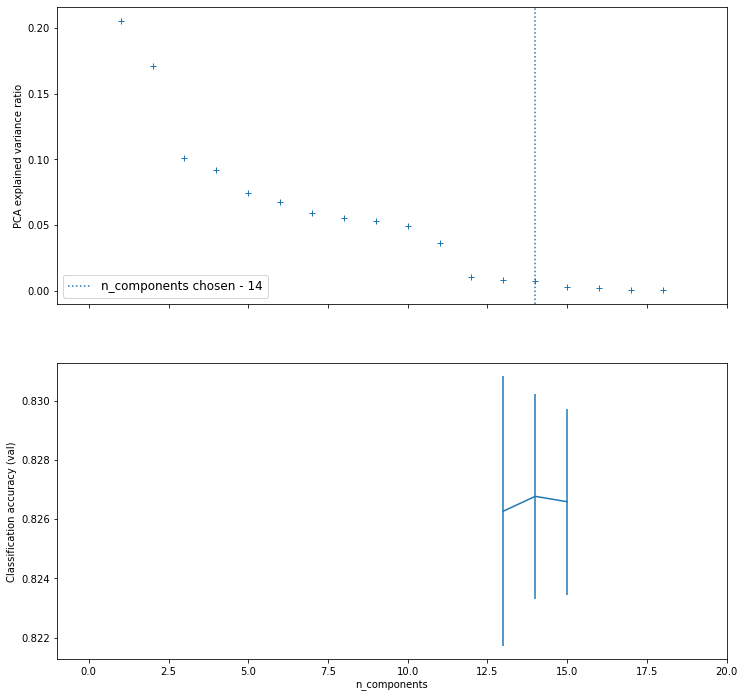

In [129]:
knn_gsrch = gsrch_clf(KNeighborsClassifier(), param_grid_knn, train_x[:22000], train_y[:22000])

Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 22.0min
[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed: 25.6min finished


Best parameter (CV score=0.845):
{'clf__bootstrap': True, 'clf__max_depth': 20, 'clf__max_features': 'auto', 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 4, 'clf__n_estimators': 800, 'pca__n_components': 12}

[[5323 1242]
 [ 747 5887]]

Accuracy: 0.8493067656640655


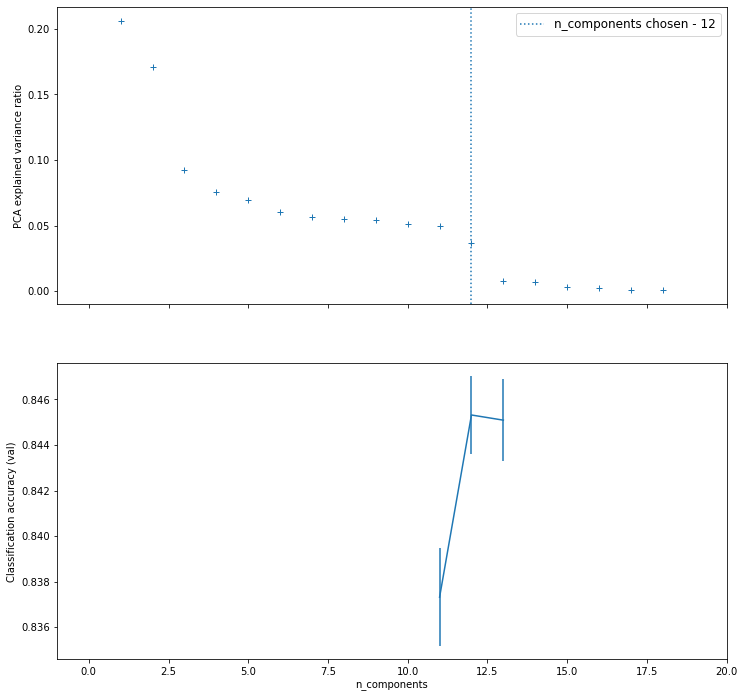

In [191]:
randfor_gsrch = gsrch_clf(RandomForestClassifier(), param_grid_randfor, train_x[:22000], train_y[:22000])

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed: 13.2min finished


Best parameter (CV score=0.979):
{'clf__bootstrap': False, 'clf__max_depth': 63, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 4, 'clf__n_estimators': 375, 'pca__n_components': 14}

[[93841  2392]
 [ 1609 94448]]

Accuracy: 0.9791928857454886


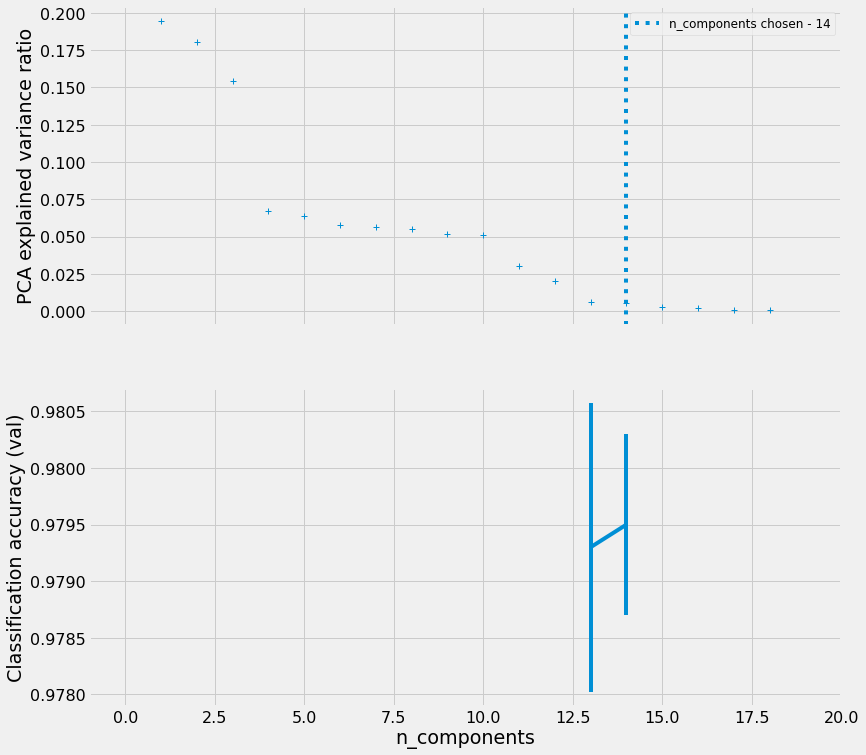

In [197]:
randfor_gsrch = gsrch_clf(RandomForestClassifier(), param_grid_randfor, train_x[:20000], train_y[:20000])

Fitting 4 folds for each of 324 candidates, totalling 1296 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 18.1min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 41.9min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 73.7min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 116.1min
[Parallel(n_jobs=-1)]: Done 1296 out of 1296 | elapsed: 122.5min finished


Best parameter (CV score=0.979):
{'clf__bootstrap': False, 'clf__max_depth': 63, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 5, 'clf__n_estimators': 375, 'pca__n_components': 13}

[[93852  2381]
 [ 1639 94418]]

Accuracy: 0.9790940766550522


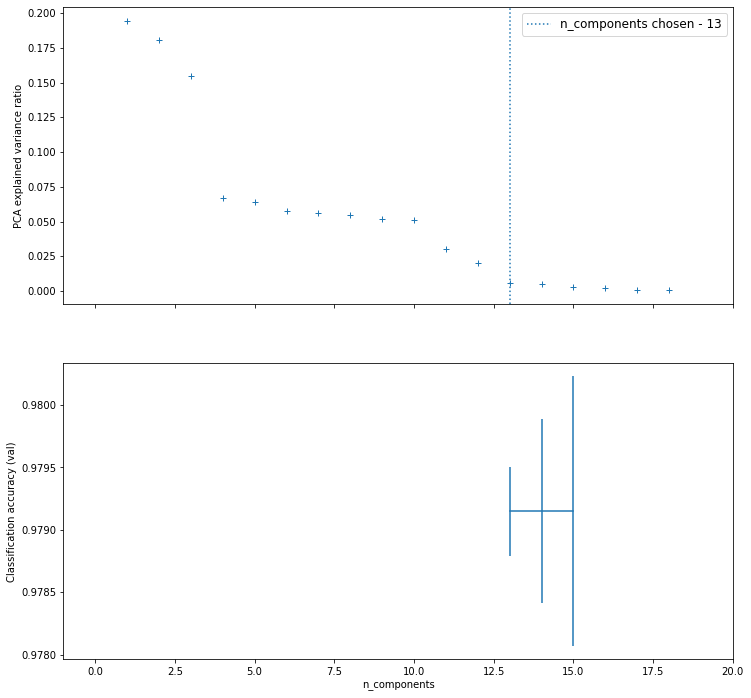

In [55]:
gsrch_clf(RandomForestClassifier(), param_grid_randfor, train_x[:20000], train_y[:20000])

In [86]:
def get_pca_feat_names(initial_feature_names, model):
    """get the feature names based on PCA analysis"""
    # number of components
    n_pcs= model.components_.shape[0]

    # get the index of the most important feature on EACH component i.e. largest absolute value
    # using list comprehension, get the maximum value after taking absolute value of the 18 components
    most_important = [np.abs(model.components_[i]).argmax() for i in range(n_pcs)]

    # get the names
    most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

    # using LIST COMPREHENSION HERE AGAIN
    dic = {'PC{}'.format(i+1): most_important_names[i] for i in range(n_pcs)}

    # build the dataframe
    df = pd.DataFrame(dic.items(), columns=['PC', 'feature_name'])
    return df

In [199]:
def estm_stats(model, train, test):
    """Returns dictionary of probability array and prediction array""" 
    if isinstance(model, dict):
        print('dict')
        model = model['gsrch_cv']
    # Stats about the trees in random forest    
    if isinstance(model.estimator['clf'], RandomForestClassifier):
        print('random forest')
        n_nodes = []
        max_depths = []
        for ind_tree in model.best_estimator_['clf'].estimators_:
            n_nodes.append(ind_tree.tree_.node_count)
            max_depths.append(ind_tree.tree_.max_depth)

        print(f'Average number of nodes {int(np.mean(n_nodes))}')
        print(f'Average maximum depth {int(np.mean(max_depths))}')

    # Training predictions (to demonstrate overfitting)
    # Testing predictions (to determine performance)
    try:
        if isinstance(model.estimator['clf'].estimator, LinearSVC):
            train_probs = model.decision_function(train) # decision function returns pairwise scores between classes; which side of the hyperplane generated by the classifier we are and how far we are away from it
            probs = model.decision_function(test)
    except AttributeError:
        pass # the if-else statement below will deal with all other cases
    
    if isinstance(model.estimator['clf'], SGDClassifier):
        train_probs = model.decision_function(train)
        probs = model.decision_function(test)
    else:
        train_probs = model.predict_proba(train)[:, 1]
        probs = model.predict_proba(test)[:, 1] # confidence interval, probability of belonging to certain class
        
    train_predictions = model.predict(train)
    predictions = model.predict(test)
    
    if isinstance(model, RandomForestClassifier):
        return {
                'n_nodes' : n_nodes,
                'max_depths' : max_depths,
                'train_pred' : train_predictions,
                'train_probs' : train_probs,
                'pred' : predictions,
                'probs' : probs
        }
    else:
        return {
                'train_pred' : train_predictions,
                'train_probs' : train_probs,
                'pred' : predictions,
                'probs' : probs
        }



def evaluate_model(predictions, probs, train_predictions, train_probs, test_labels, train_labels, figsz=(8, 6)):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    
    # Plot formatting
    plt.style.use('fivethirtyeight')
    plt.rcParams['font.size'] = 18
    
    baseline = {}
    
    baseline['recall'] = recall_score(test_labels, 
                                     [1 for _ in range(len(test_labels))])
    baseline['precision'] = precision_score(test_labels, 
                                      [1 for _ in range(len(test_labels))])
    baseline['roc'] = 0.5
    
    results = {}
    results['recall'] = recall_score(test_labels, predictions) #TPR 
    results['precision'] = precision_score(test_labels, predictions)
    results['roc'] = roc_auc_score(test_labels, probs) #reciever operating characteristics
    
    train_results = {}
    train_results['recall'] = recall_score(train_labels, train_predictions)
    train_results['precision'] = precision_score(train_labels, train_predictions)
    train_results['roc'] = roc_auc_score(train_labels, train_probs)
    
    for metric in ['recall', 'precision', 'roc']: # capitalize just the first letter
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(test_labels, [1 for _ in range(len(test_labels))])
    model_fpr, model_tpr, _ = roc_curve(test_labels, probs)

    plt.figure(figsize = figsz)
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate'); 
    plt.ylabel('True Positive Rate'); plt.title('ROC Curves');
    plt.show();

In [75]:
def calc_clf_stats(pipe, train_x, test_x, clf='rf'):
    """only used with the pipeline that changed the amount of PC"""
    # get the column names that are most important according to PCA analysis
    
    filter_by_feat_names = get_pca_feat_names(list(train_x), pipe['pca'])['feature_name'].values
    
    # index based on the selected columns for train and test sets
    train_x_filter_pca_compt = train_x.loc[:, filter_by_feat_names]
    test_x_filter_pca_compt = test_x.loc[:, filter_by_feat_names]
    
    # return a dictionary with the parameters

    res_dat = rf_estm_stats(pipe[clf], train_x_filter_pca_compt, test_x_filter_pca_compt)
    
    return res_dat


def plt_eval(res_dat, test_y, train_y):
    """
    This is an imbalanced classification problem, so accuracy is not an appropriate metric. 
    Instead we'll measure the Receiver Operating Characteristic Area Under the Curve (ROC AUC), 
    a measure from 0 (worst) to 1 (best) with a random guess scoring 0.5. We can also plot the 
    ROC curve to assess a model.

    """
    evaluate_model(res_dat['pred'], res_dat['probs'], res_dat['train_pred'], res_dat['train_probs'], test_y, train_y)

    

In [76]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges,
                          figsz=(10, 10)):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # insert new axis in nparray in order to divide the two arrays
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    print()
    
    # Plot the confusion matrix
    plt.figure(figsize = figsz)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    # itertools.product([1,2,3],[3,4])) --> [(1, 3), (1, 4), (2, 3), (2, 4), (3, 3), (3, 4)]
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

##### using the Pipeline classifier

Average number of nodes 25477
Average maximum depth 49
Recall Baseline: 1.0 Test: 0.0 Train: 0.0
Precision Baseline: 0.5 Test: 0.95 Train: 0.96
Roc Baseline: 0.5 Test: 0.63 Train: 0.63


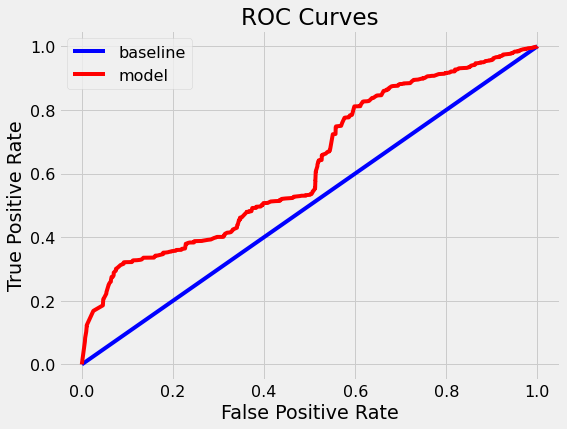

In [192]:
res_dat = calc_clf_stats(rf_pipe, train_x, test_x)
plt_eval(res_dat, test_y, train_y)

Confusion matrix, without normalization
[[ 9947     4]
 [10038    11]]



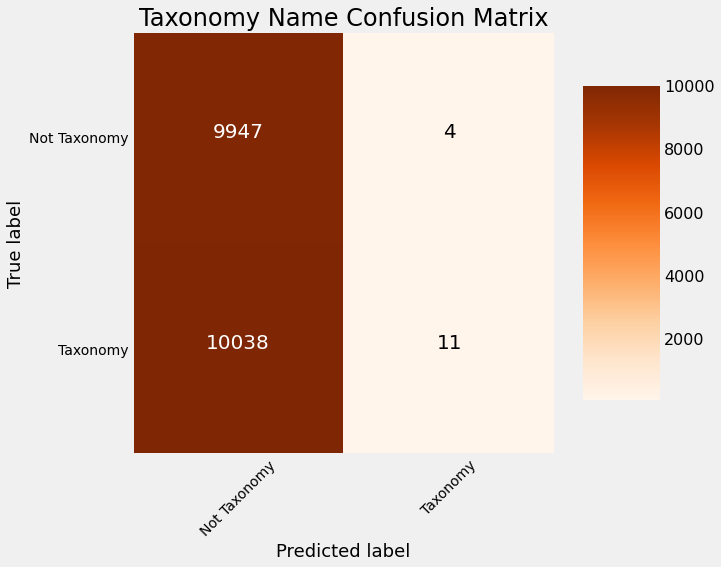

In [144]:
# Confusion matrix with Pipeline
cm = confusion_matrix(y_true = test_y[:20000], y_pred = res_dat['rf_pred'])
plot_confusion_matrix(cm, classes = ['Not Taxonomy', 'Taxonomy'],
                      title = 'Taxonomy Name Confusion Matrix')

In [185]:
y_pred = rf_pipe['rf'].predict(test_x.loc[:,get_pca_feat_names(list(train_x), rf_pipe['pca'])['feature_name'].values])
cm = confusion_matrix(test_y, y_pred)
print(cm)

[[96226     7]
 [95912   145]]


In [174]:
rf_pipe['rf'].predict(np.array([format_feats_into_df('Sparasion embolicus')[cn] for cn in get_pca_feat_names(list(train_x), rf_pipe['pca'])['feature_name'].values]).reshape(1,-1))

array([False])

In [164]:
for i in range(100):
    idx = test_x.index[i]
    cls_res = rf_pipe['rf'].predict(np.array(test_x.loc[idx,get_pca_feat_names(list(train_x), rf_pipe['pca'])['feature_name'].values]).reshape(1,-1))
    print(f'{idx} - {cls_res}')

100350 - [False]
155442 - [False]
730011 - [False]
91818 - [False]
279251 - [False]
604010 - [False]
129608 - [False]
422212 - [False]
385186 - [False]
714891 - [False]
687310 - [False]
370632 - [False]
540073 - [False]
419134 - [False]
359582 - [False]
755104 - [False]
865388 - [False]
14646 - [False]
940977 - [False]
90593 - [False]
486156 - [False]
507058 - [False]
860067 - [False]
642747 - [False]
100448 - [False]
879492 - [False]
599269 - [False]
746289 - [False]
677174 - [False]
573649 - [False]
393771 - [False]
907305 - [False]
223508 - [False]
588328 - [False]
670618 - [False]
284625 - [False]
169959 - [False]
765755 - [False]
359706 - [False]
190387 - [False]
655020 - [False]
623454 - [False]
597523 - [False]
744739 - [False]
456011 - [False]
187071 - [False]
85494 - [False]
924307 - [False]
836024 - [False]
672023 - [False]
228860 - [False]
230113 - [False]
766914 - [False]
706760 - [False]
802292 - [False]
266017 - [False]
125208 - [False]
668055 - [False]
934677 - [False]
7

##### using the GridSearchCV classifier

In [276]:
randfor_gsrch['gsrch_cv'].estimator['clf']

RandomForestClassifier()

In [304]:
res_data = estm_stats(randfor_gsrch, train_x, test_x)

dict
random forest
Average number of nodes 1311
Average maximum depth 27


Recall Baseline: 1.0 Test: 0.98 Train: 0.98
Precision Baseline: 0.5 Test: 0.98 Train: 0.98
Roc Baseline: 0.5 Test: 1.0 Train: 1.0


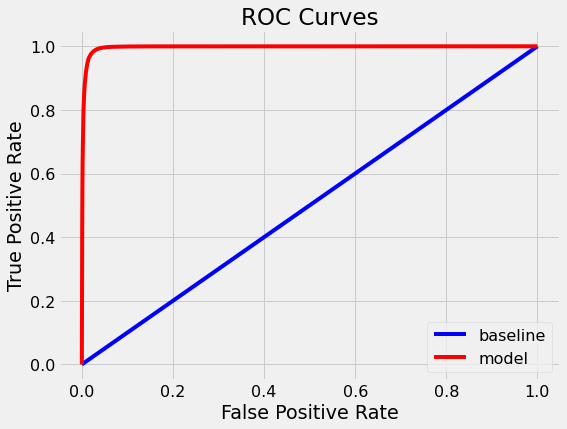

In [267]:
evaluate_model(res_data['pred'], res_data['probs'], res_data['train_pred'], res_data['train_probs'], test_y, train_y)

Confusion matrix, without normalization
[[93841  2392]
 [ 1609 94448]]



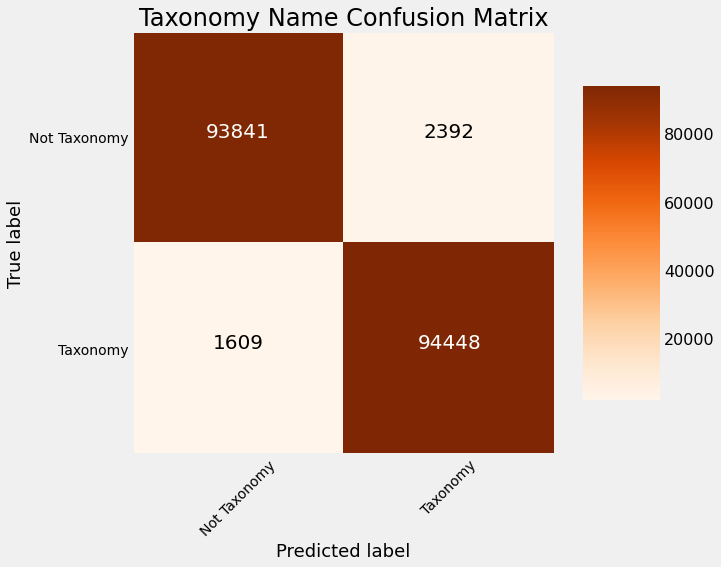

In [199]:
# Confusion matrix using gridsearchCV
cm = confusion_matrix(y_true = test_y, y_pred = randfor_gsrch['gsrch_cv'].predict(test_x))
plot_confusion_matrix(cm, classes = ['Not Taxonomy', 'Taxonomy'],
                      title = 'Taxonomy Name Confusion Matrix')

In [309]:
joblib.dump(randfor_gsrch['gsrch_cv'].best_estimator_, 'models/rf_taxon_names.pkl', compress = 1)

['models/rf_taxon_names.pkl']

In [203]:
randfor_gsrch['gsrch_cv'].predict(np.array(format_feats_into_df('Tom Faulker`')).reshape(1,-1))

array([ True])

In [137]:
words = ['Calm Disgust',
'Obnoxious Root',
'Female Station',
'Hellish Slope',
'Crowded Feather',
'Towering Heat',
'Deep Kick',
'Forgetful Plane',
'Economic Ducks',
'Lean North',
'Mailbox Bat',
'Lawyer Addition',
'Receipt Activity',
'Meeting Pain',
'Join Believe',
'Cows Eyes',
'Rake Stove',
'Shade Side',
'Car Ticket',
'Donkey Cloth',
'Offer Yoke',
'Assure Leaf',
'Attain Dirt',
'Surprise Transport',
'Zoom Scent',
'Form Women',
'Saw Watch',
'Fry Deer',
'Spray Sense',
'Wed Chin',
'Adrian Slang',
'Wizard Chess',
'Frank Decade',
'Sardine Balloon',
'Before Eddie',
'Spray Harvest',
'Legend Anvil',
'Copy System',
'School Secure',
'Teacher Herbert',
'Complex Comparison',
'Boring Basket',
'Accessible Advice',
'Amazing Act',
'Sneaky Sheep',
'Big Brake',
'Last Language',
'Common Cent',
'Premium Pin',
'Spicy Skirt',
'Country Cry',
'Store Sense',
'Cracker Cellar',
'Spoon Scene',
'Pear Plantation',
'Dinner Dock',
'Spark Seashore',
'Peace Property',
'Bat Brake',
'Marble Milk',
'Multiply Mitten',
'Print Pigs',
'Forbid Flight',
'Freeze Father',
'Settle Smell',
'Create Connection',
'Cough Clocks',
'Scrape String',
'Bury Badge',
'Spin Spoon',
'Bicycle Botanic',
'Fuel Frog',
'Prefix Plato',
'Rose Rudolf',
'Palace Popcorn',
'Club Cover',
'Pioneer Potato',
'Bridge Bandit',
'Garlic Grace',
'Change Cobalt']

In [139]:
def test_model_fwords(model):
    for w in words:
        try:
            if model['gsrch_cv'].predict(np.array(format_feats_into_df(w)).reshape(1,-1))[0]:
                print(w)
        except KeyError:
            print(w)

In [140]:
test_model_fwords(knn_gsrch)

Car Ticket
Saw Watch
Fry Deer
Wed Chin
Complex Comparison
Big Brake
Premium Pin
Bat Brake
Pioneer Potato


In [202]:
test_model_fwords(randfor_gsrch)

Car Ticket
Saw Watch
Fry Deer
Wed Chin
Complex Comparison
Big Brake
Bat Brake
Pioneer Potato


In [144]:
def test_model_2(model):
    test_taxname = ['Pittosporum viridiflorum',\
                    'Tubastraea faulkneri',\
                    'Portieria hornemannii',\
                    'Alternative prospectus',\
                    'TUBASTREA FAULMVERl']
    for tx in test_taxname:
        print(model['gsrch_cv'].predict(np.array(format_feats_into_df(tx)).reshape(1,-1)))

In [145]:
test_model_2(knn_gsrch)

[ True]
[ True]
[ True]
[False]
[ True]


In [205]:
test_model_2(randfor_gsrch)

[ True]
[ True]
[ True]
[False]
[ True]


In [195]:
res_data = estm_stats(randfor_gsrch, train_x, test_x)

dict
random forest
Average number of nodes 3123
Average maximum depth 20


Recall Baseline: 1.0 Test: 0.89 Train: 0.91
Precision Baseline: 0.5 Test: 0.83 Train: 0.85
Roc Baseline: 0.5 Test: 0.92 Train: 0.94


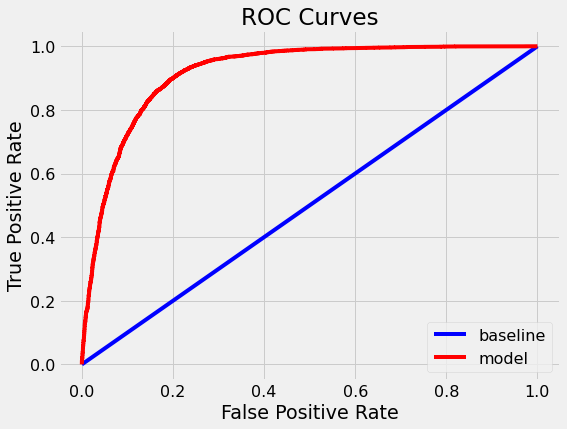

In [197]:
evaluate_model(res_data['pred'], res_data['probs'], res_data['train_pred'], res_data['train_probs'], test_y, train_y)

Confusion matrix, without normalization
[[5323 1242]
 [ 747 5887]]



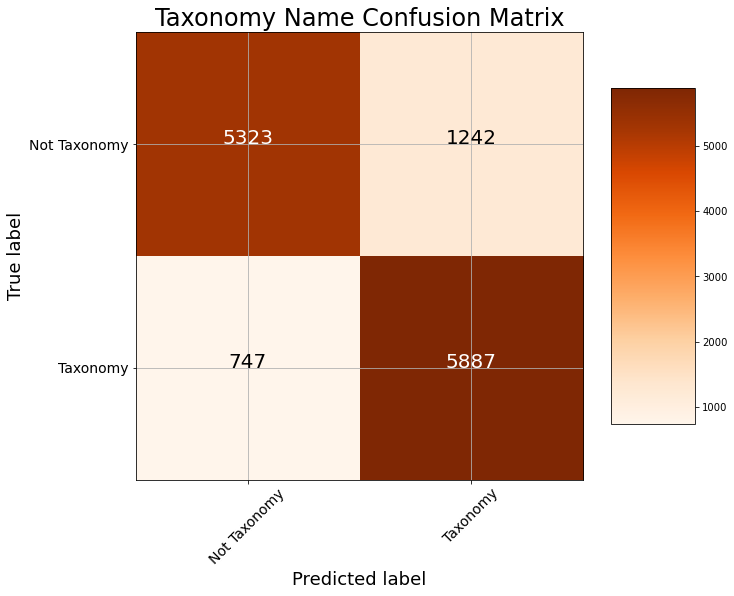

In [196]:
# using gridsearchcv with newest dataset (use of science corpora)
cm = confusion_matrix(y_true = test_y, y_pred = randfor_gsrch['gsrch_cv'].predict(test_x))
plot_confusion_matrix(cm, classes = ['Not Taxonomy', 'Taxonomy'],
                      title = 'Taxonomy Name Confusion Matrix')

In [178]:
def show_cm(model, test_x, test_y, ):
    try:
        if isinstance(model.estimator['clf'].estimator, LinearSVC):
            model_type = type(linsvc_gsrch['gsrch_cv'].estimator['clf'].estimator).__name__
    except AttributeError:
        model_type = type(model['gsrch_cv'].estimator['clf']).__name__
    cm = confusion_matrix(y_true = test_y, y_pred = model['gsrch_cv'].predict(test_x))
    plot_confusion_matrix(cm, classes = ['Not Taxonomy', 'Taxonomy'],
                          title = f'Taxonomy Name Confusion Matrix - {model_type}')

In [ ]:
# KNN 
show_cm(knn_gsrch, test_x, test_y)

In [80]:
def plot_roc(model, train_x, test_x, train_y, test_y):
    res_data = estm_stats(model, train_x, test_x)
    evaluate_model(res_data['pred'], res_data['probs'], res_data['train_pred'], res_data['train_probs'], test_y, train_y)

dict
Recall Baseline: 1.0 Test: 0.88 Train: 0.88
Precision Baseline: 0.5 Test: 0.8 Train: 0.82
Roc Baseline: 0.5 Test: 0.89 Train: 0.91


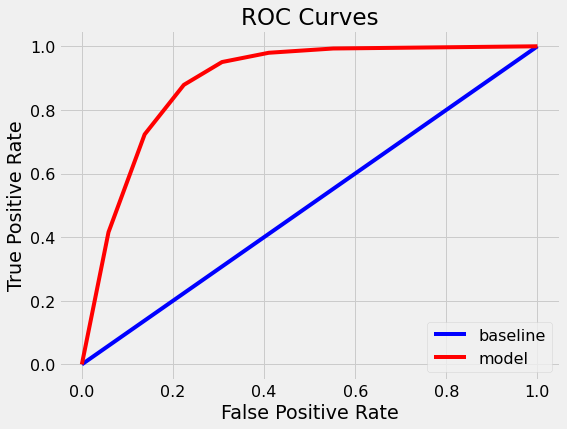

In [136]:
plot_roc(knn_gsrch, train_x, test_x, train_y, test_y)

Recall Baseline: 1.0 Test: 0.83 Train: 0.84
Precision Baseline: 0.5 Test: 0.79 Train: 0.78
Roc Baseline: 0.5 Test: 0.88 Train: 0.88


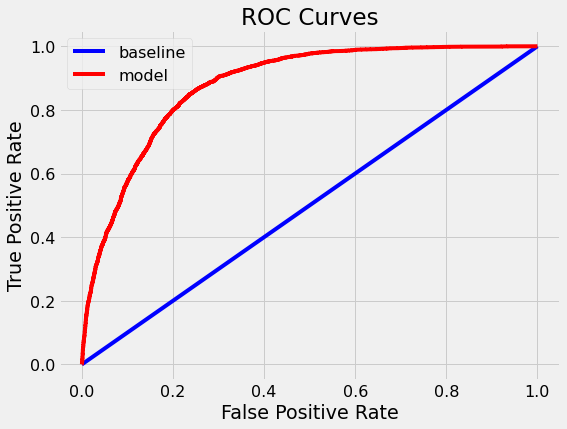

In [107]:
plot_roc(linsvc_gsrch['gsrch_cv'], train_x, test_x, train_y, test_y)

Confusion matrix, without normalization
[[5117 1494]
 [1096 5492]]



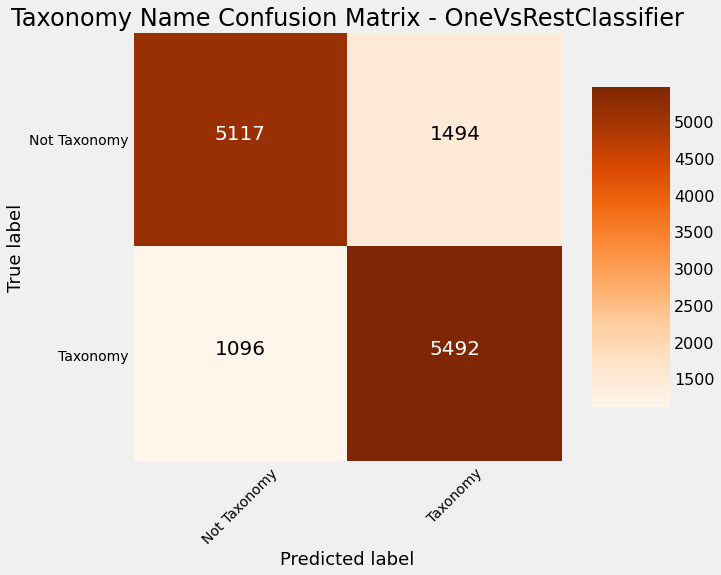

In [169]:
show_cm(linsvc_gsrch, test_x, test_y)

Recall Baseline: 1.0 Test: 0.83 Train: 0.83
Precision Baseline: 0.5 Test: 0.79 Train: 0.79
Roc Baseline: 0.5 Test: 0.88 Train: 0.88


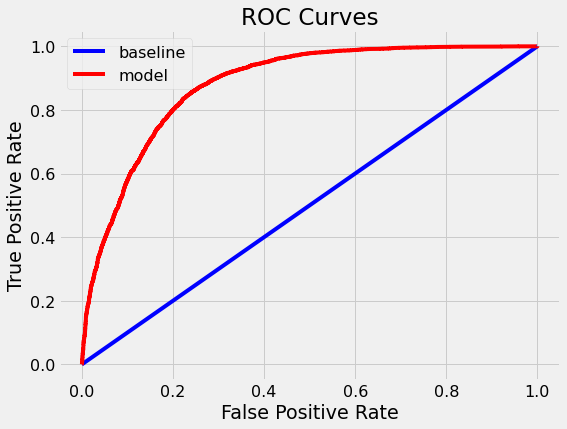

In [140]:
plot_roc(logreg_gsrch['gsrch_cv'], train_x, test_x, train_y, test_y)

Recall Baseline: 1.0 Test: 0.74 Train: 0.75
Precision Baseline: 0.5 Test: 0.73 Train: 0.73
Roc Baseline: 0.5 Test: 0.82 Train: 0.82


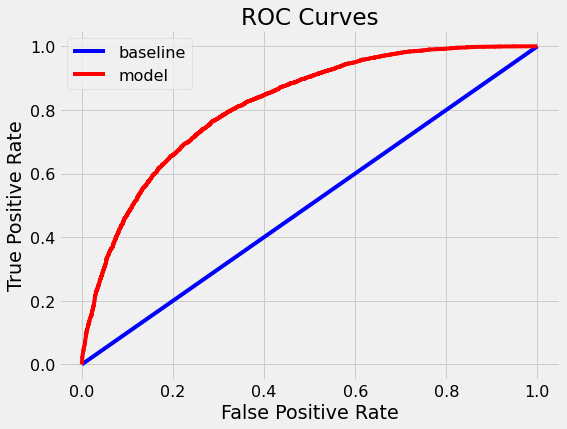

In [183]:
plot_roc(bern_gsrch['gsrch_cv'], train_x, test_x, train_y, test_y)

Recall Baseline: 1.0 Test: 0.83 Train: 0.83
Precision Baseline: 0.5 Test: 0.75 Train: 0.75
Roc Baseline: 0.5 Test: 0.85 Train: 0.85


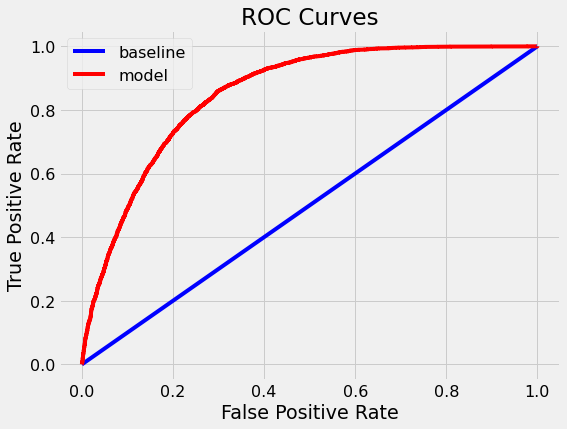

In [200]:
plot_roc(sgd_gsrch['gsrch_cv'], train_x, test_x, train_y, test_y)

Confusion matrix, without normalization
[[5160 1451]
 [1138 5450]]



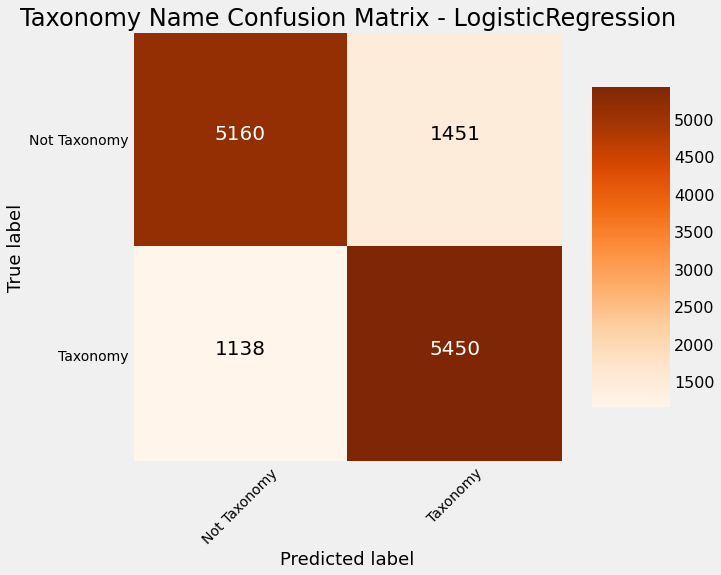

In [179]:
show_cm(logreg_gsrch, test_x, test_y)

Confusion matrix, without normalization
[[4850 1761]
 [1711 4877]]



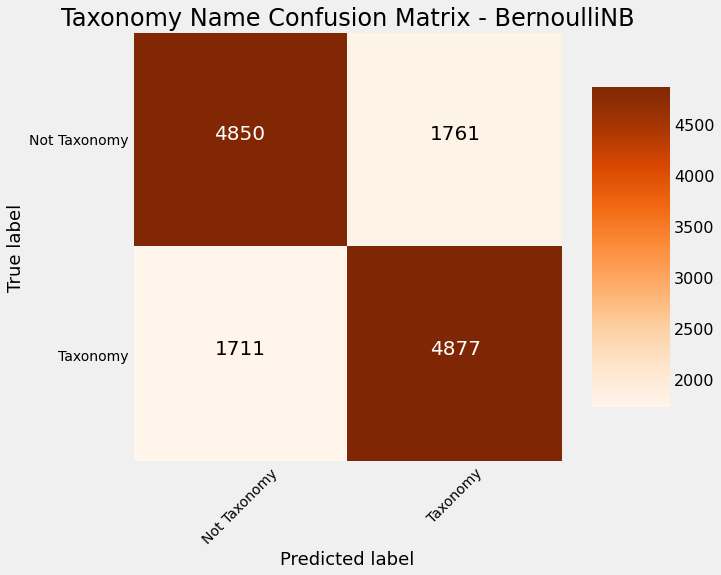

In [180]:
show_cm(bern_gsrch, test_x, test_y)

Confusion matrix, without normalization
[[4761 1850]
 [1103 5485]]



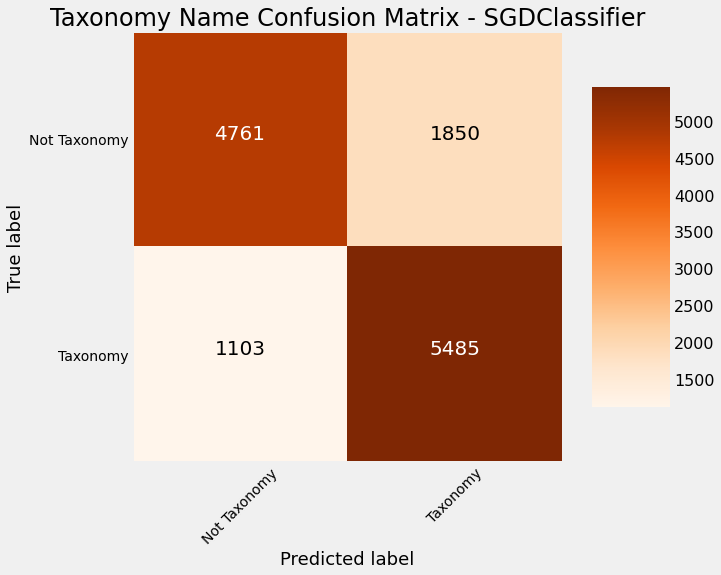

In [181]:
show_cm(sgd_gsrch, test_x, test_y)

In [200]:
joblib.dump(randfor_gsrch['gsrch_cv'].best_estimator_, 'models/rf_taxon_names_v2.pkl', compress = 1)

['models/rf_taxon_names_v2.pkl']

In [133]:
joblib.dump(knn_gsrch['gsrch_cv'].best_estimator_, 'models/knn_taxon_names_v2.pkl', compress = 1)

['models/knn_taxon_names_v2.pkl']

In [79]:
def save_model(model, name):
    """save the model after running randomsrchCV and gridsearchCV"""
    fi_name = f'models/{name}_taxon_names.pkl'
    joblib.dump(model['gsrch_cv'].best_estimator_,fi_name, compress = 1)
    print(f'saved ... {fi_name}')

In [78]:
save_model(linsvc_gsrch, 'linsvc')

In [135]:
save_model(sgd_gsrch, 'sgd')

saved ... models/sgd_taxon_names.pkl


In [136]:
save_model(logreg_gsrch, 'logreg')

saved ... models/logreg_taxon_names.pkl


In [ ]:
save_model(bern_gsrch, 'bern')